In [2]:
import requests
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import time
%matplotlib inline

## API Call functions

In [58]:
def ergast_get_standings(year, race):
    '''call ergast api to get driver standings for a giver year and race number'''
    url = f'http://ergast.com/api/f1/{year}/{race}/driverStandings.json'
    data = requests.get(url).json()

    standings = {}

    # parse json object and retrieve standings
    for x, driver in enumerate(data['MRData']['StandingsTable']['StandingsLists'][0]['DriverStandings']):
        position = driver['position']
        driver_id = driver['Driver']['driverId']
        standings[driver_id] = position
    
    # conver to df, rename the column and change data type
    standings = pd.DataFrame.from_dict(standings, orient='index').rename(columns={0:'standing'}).apply(pd.to_numeric)
    
    return standings

def ergast_get_pitstops(year, race):
    '''
    call ergast api to get pitstops for a given year and race number.
    returns a pandas dataframe containing piststops for each race of the event for each driver.
    '''

    # call API and get json object response
    url = f'http://ergast.com/api/f1/{year}/{race}/pitstops.json'
    data = requests.get(url).json()

    # empty data to append data to in the case that there are > 1 'Races' in the json object
    pitstops = pd.DataFrame()

    # parse Json object to obtain the pitstops table.
    for x, race in enumerate(data['MRData']['RaceTable']['Races']):
        pit_stops = pd.DataFrame(race['PitStops']).set_index('driverId')
        pitstops = pitstops.append(pit_stops)

    return pitstops

def ergast_get_races(year):
    url = f'http://ergast.com/api/f1/{year}/races.json'
    data = requests.get(url).json()

    race_list = []
    
    for x, race in enumerate(data['MRData']['RaceTable']['Races']):
        race_list.append(race['round'])

    return race_list

In [4]:
standings = pd.read_csv('f1db_csv/driver_standings.csv')
standings = standings.groupby(['raceId', 'driverId']).sum('wins')
standings


driverStandingsId  points  position  wins
raceId driverId                                           
1      2                      8256     0.0        10     0
       3                      8252     3.0         6     0
       4                      8251     4.0         5     0
       7                      8254     1.0         8     0
       8                      8261     0.0        15     0
...                            ...     ...       ...   ...
1075   848                   71284     0.0        18     0
       849                   71287     0.0        20     0
       852                   71279     4.0        11     0
       854                   71282     0.0        15     0
       855                   71281     1.0        14     0

[33455 rows x 4 columns]

In [5]:
pit_stops = pd.read_csv('f1db_csv/pit_stops.csv')
pit_stops = pit_stops.groupby(['raceId', 'driverId']).sum().drop(columns=['stop', 'lap'])
pit_stops

milliseconds
raceId driverId              
841    1                46426
       2                48092
       3                23716
       4                72165
       5                24865
...                       ...
1075   844              21038
       846              20383
       847              21415
       848              20683
       855              48837

[4328 rows x 1 columns]

In [30]:
joined_data = pd.concat([pit_stops, standings], join='inner', axis='columns')
joined_data = joined_data[joined_data['milliseconds']<100000]
joined_data = joined_data.groupby('position').mean().reset_index().head(21)
joined_data

,position,milliseconds,driverStandingsId,points,wins
0,1,44447.683417,67685.502513,194.811558,5.175879
1,2,44678.707071,67686.595960,161.305556,2.606061
2,3,45341.036082,67654.546392,128.268041,0.917526
3,4,46629.289474,67622.489474,107.973684,0.421053
4,5,46009.387435,67705.696335,95.856021,0.361257
5,6,46813.085561,67630.909091,75.935829,0.443850
6,7,43569.539683,67691.761905,54.931217,0.042328
7,8,44730.127660,67684.441489,47.734043,0.063830
8,9,46717.759358,67666.411765,37.053476,0.016043
9,10,44348.203297,67800.576923,29.961538,0.038462


<AxesSubplot:xlabel='milliseconds'>

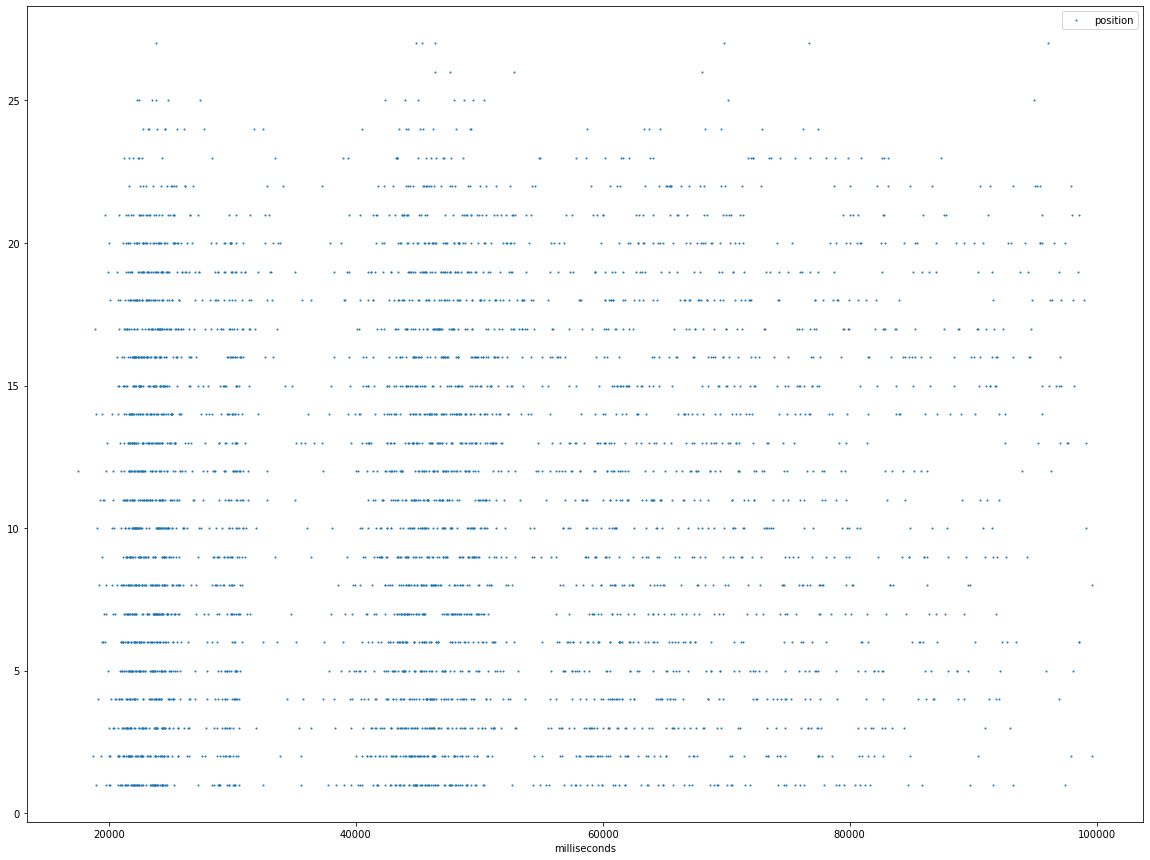

In [175]:
joined_data.plot(x='milliseconds', y='position',linestyle='None', marker='o', markersize=1, figsize=(20,15))

array([[<AxesSubplot:title={'center':'milliseconds'}>]], dtype=object)

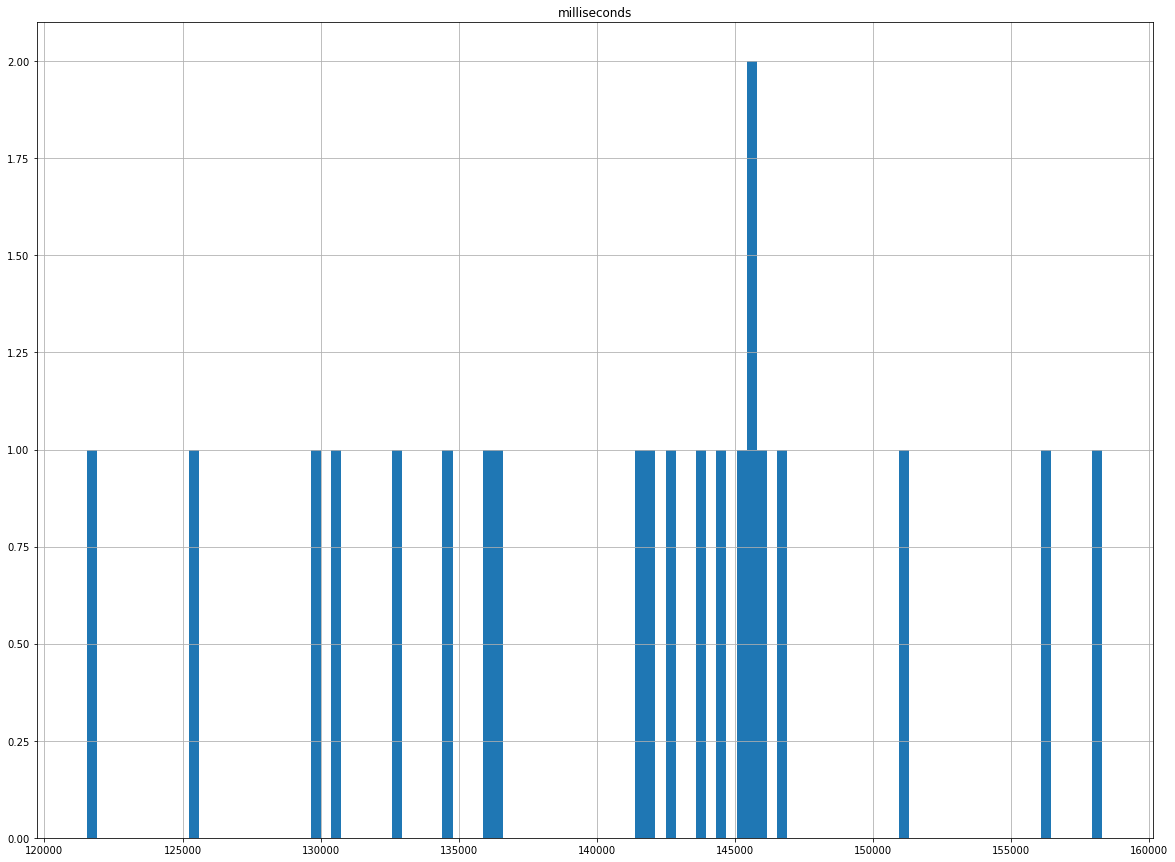

In [29]:
joined_data.hist('milliseconds', bins = 100, figsize=(20,15))

In [27]:
px.scatter(joined_data, x='position', y='milliseconds', trendline="ols")